In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from keras.utils import Sequence
import numpy as np
import pandas as pd
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import os
print(os.listdir("../input"))

class DataGenerator(Sequence):
    def __init__(self, in1, in2, in3, in4, in5, ySet):
        self.in1, self.in2, self.in3, self.in4, self.in5 = in1, in2, in3, in4, in5
        self.y = ySet

    def __len__(self):
        return len(self.in1)

    def __getitem__(self, idx):
        batch1 = self.in1[idx]
        batch1 = batch1[np.newaxis, :, :]
        batch2 = self.in2[idx]
        batch2 = batch2[np.newaxis, :, :]
        batch3 = self.in3[idx]
        batch3 = batch3[np.newaxis, :, :]
        batch4 = self.in4[idx]
        batch4 = batch4[np.newaxis, :, :]
        batch5 = self.in5[idx]
        batch5 = batch5[np.newaxis, :, :]
        if self.y.empty:   # condition for predict generator.
            return [batch1,batch2,batch3,batch4,batch5]
        else:
            batchY = self.y[idx]
            return [batch1,batch2,batch3,batch4,batch5], np.atleast_2d(batchY)

apptrain = pd.read_csv('../input/application_train.csv', index_col='SK_ID_CURR')
apptest = pd.read_csv('../input/application_test.csv', index_col='SK_ID_CURR')
apptrain = apptrain.select_dtypes(exclude='object')
apptest = apptest.select_dtypes(exclude='object')
for col in apptrain.columns:
    if col != 'TARGET':
        apptrain[col] = scaler.fit_transform(apptrain[[col]])
        apptest[col] = scaler.transform(apptest[[col]])
filelist = ['credit_card_balance','previous_application','POS_CASH_balance','installments_payments','bureau']
print(filelist[0])
df_dict = dict()
df_dict_train = dict()
df_dict_test = dict()
def myfunc(grObj):
    arr1 = np.array(grObj)
    return arr1
for file in filelist:
    file_str = "../input/%s.csv" % (file)
    df_dict[file] = pd.read_csv(file_str, index_col='SK_ID_CURR')
    df_dict[file] = df_dict[file].select_dtypes(exclude='object')
    df_dict[file] = df_dict[file].loc[:, ~df_dict[file].columns.isin(['SK_ID_PREV','SK_ID_BUREAU'])] ## removing extra indices
    ### merging the input file with train and test indices to handle missing indices and sorting.
    df_dict_train[file] = pd.merge(apptrain[apptrain.columns[0:2]], df_dict[file], how='left',
                              on=['SK_ID_CURR'])
    df_dict_test[file] = pd.merge(apptest[apptest.columns[0:2]], df_dict[file], how='left',
                              on=['SK_ID_CURR'])
    df_dict_train[file].drop(df_dict_train[file].columns[0:2], axis=1, inplace=True)
    df_dict_test[file].drop(df_dict_test[file].columns[0:2], axis=1, inplace=True)
    ### scaling each column
    for col in df_dict[file].columns:
        df_dict_train[file][col] = scaler.fit_transform(df_dict_train[file][[col]])
        df_dict_test[file][col] = scaler.transform(df_dict_test[file][[col]])
    df_dict_train[file] = df_dict_train[file].fillna(0)
    # Creating groupby object and making dataframe of arbitrary length numpy arrays.
    df_dict_train[file] = df_dict_train[file].groupby('SK_ID_CURR')
    df_dict_train[file] = df_dict_train[file].apply(myfunc)
    ###
    df_dict_train[file] = df_dict_train[file].reset_index(drop=True)
    
    df_dict_test[file] = df_dict_test[file].fillna(0)
    df_dict_test[file] = df_dict_test[file].groupby('SK_ID_CURR')
    df_dict_test[file] = df_dict_test[file].apply(myfunc)
    df_dict_test[file] = df_dict_test[file].reset_index(drop=True)
yTrain = apptrain['TARGET']    
yTrain = yTrain.reset_index(drop=True)
# Network definition:
#Simple RNN for converting the arbitrary length of batch size to single length.
#Each input node represents one input file.
input1 = Input(shape=(None, df_dict_train[filelist[0]][0].shape[1]))
rnn1 = SimpleRNN(df_dict_train[filelist[0]][0].shape[1])(input1)
dense1_1 = Dense(8, activation='relu')(rnn1)
input2 = Input(shape=(None, df_dict_train[filelist[1]][0].shape[1]))
rnn2 = SimpleRNN(df_dict_train[filelist[1]][0].shape[1])(input2)
dense2_1 = Dense(8, activation='relu')(rnn2)
input3 = Input(shape=(None, df_dict_train[filelist[2]][0].shape[1]))
rnn3 = SimpleRNN(df_dict_train[filelist[2]][0].shape[1])(input3)
dense3_1 = Dense(8, activation='relu')(rnn3)
input4 = Input(shape=(None, df_dict_train[filelist[3]][0].shape[1]))
rnn4 = SimpleRNN(df_dict_train[filelist[3]][0].shape[1])(input4)
dense4_1 = Dense(8, activation='relu')(rnn4)
input5 = Input(shape=(None, df_dict_train[filelist[4]][0].shape[1]))
rnn5 = SimpleRNN(df_dict_train[filelist[4]][0].shape[1])(input5)
dense5_1 = Dense(8, activation='relu')(rnn5)

merge = concatenate([dense1_1,dense2_1,dense3_1,dense4_1,dense5_1])
dense = Dense(50, activation='relu')(merge)
output = Dense(1)(dense)
model = Model(inputs=[input1,input2,input3,input4,input5],outputs=output)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc', 'mse'])
trainGenerator = DataGenerator(df_dict_train[filelist[0]], df_dict_train[filelist[1]], df_dict_train[filelist[2]], df_dict_train[filelist[3]], df_dict_train[filelist[4]], yTrain)
testGenerator = DataGenerator(df_dict_test[filelist[0]], df_dict_test[filelist[1]], df_dict_test[filelist[2]], df_dict_test[filelist[3]], df_dict_test[filelist[4]], pd.Series())
model.fit_generator(generator=trainGenerator,steps_per_epoch=len(yTrain))
y = model.predict_generator(generator=testGenerator)
yhat = pd.DataFrame()
yhat['SK_ID_CURR'] = appTrain.index
yhat['TARGET'] = y.flatten()
yhat.to_csv('yout.csv')
print(yhat)

['installments_payments.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'bureau.csv', 'application_test.csv', 'application_train.csv', 'POS_CASH_balance.csv', 'sample_submission.csv', 'previous_application.csv']


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return sel

credit_card_balance


/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar inst

Epoch 1/1
 47383/307511 [===>..........................] - ETA: 35:15 - loss: 1.2941 - acc: 0.0940 - mean_squared_error: 3.6599

KeyboardInterrupt: 

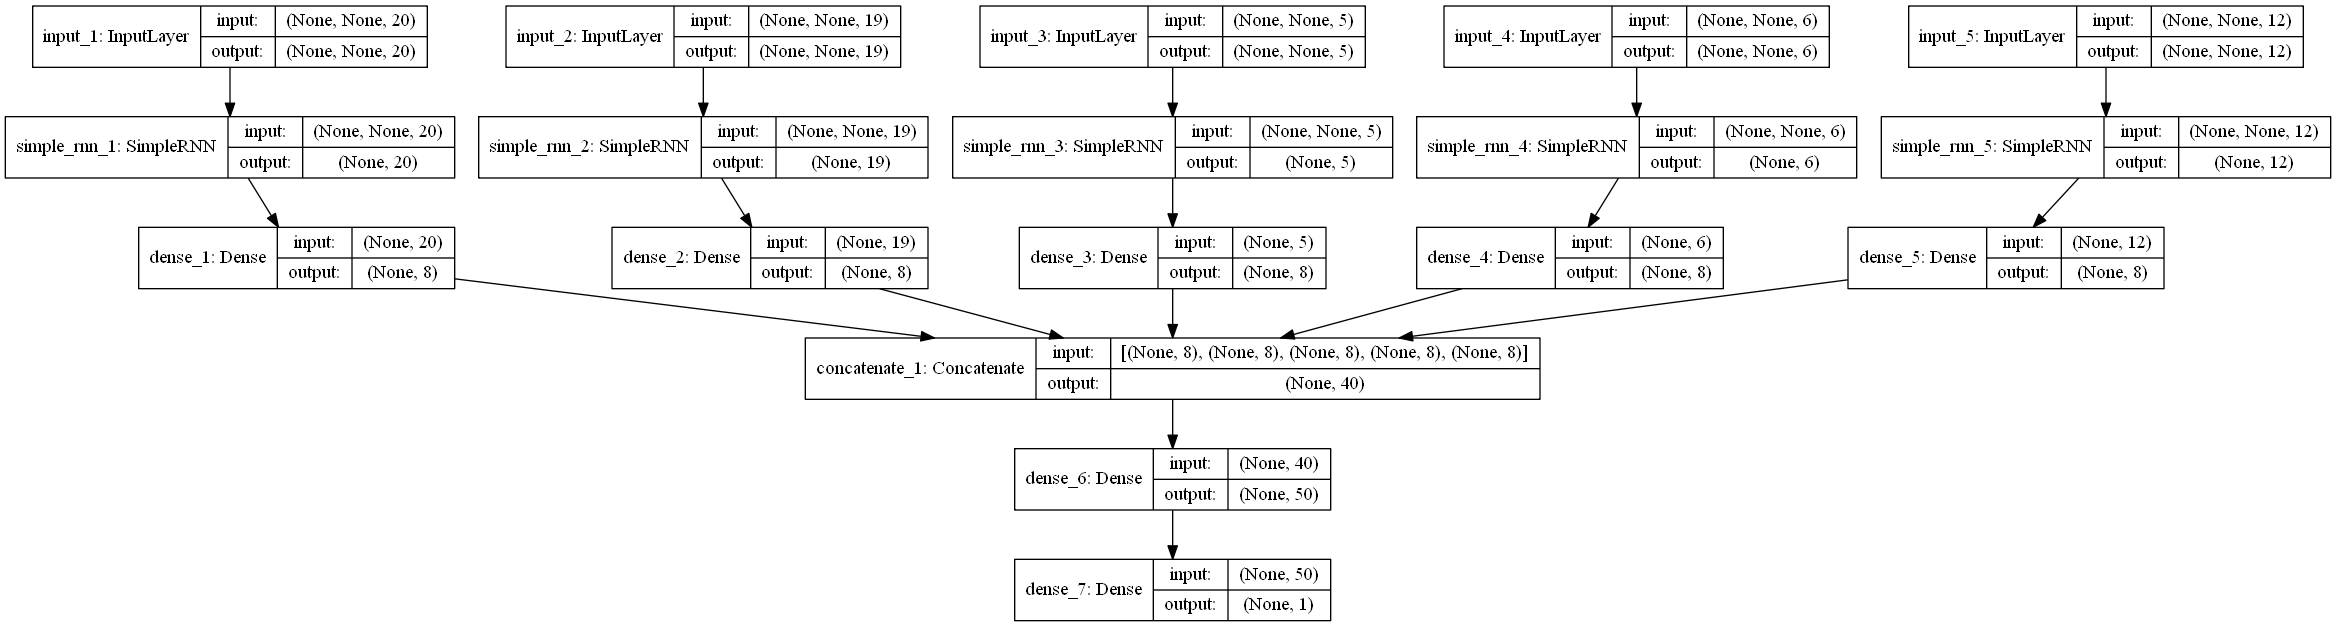